In [1]:
import os
import time
import pickle
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy import interpolate
from datetime import datetime
import pandas as pd
from tool import EarlyStopping
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error, r2_score
from common import *
from net import CRNN

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler, TensorDataset
from torch.utils.data.sampler import RandomSampler
    
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

# 1-Data preparation

If readers need to run this code, another dataset should be downloaded and put in the path './data/ne_data'

In [26]:
!python prepare_ne_data.py

41 43 40
a1 length is 1983 v_max: 1.0018 q_max: 0.8224 dv_max: 0.8472 dq_max: 0.3220
a3 length is 1293 v_max: 1.0018 q_max: 0.7710 dv_max: 0.8890 dq_max: 0.0080
a5 length is 949 v_max: 1.0017 q_max: 0.7657 dv_max: 0.5745 dq_max: 0.0105
a7 length is 738 v_max: 1.0015 q_max: 0.8020 dv_max: 0.5856 dq_max: 0.1774
a11 length is 660 v_max: 1.0016 q_max: 0.7261 dv_max: 0.8806 dq_max: 0.0158
a15 length is 595 v_max: 1.0018 q_max: 0.7420 dv_max: 0.6090 dq_max: 0.0106
a17 length is 730 v_max: 1.0018 q_max: 0.7604 dv_max: 0.5849 dq_max: 0.0132
a19 length is 658 v_max: 1.0018 q_max: 0.7762 dv_max: 0.8919 dq_max: 0.0027
a21 length is 440 v_max: 1.0018 q_max: 0.7711 dv_max: 0.8958 dq_max: 0.0027
a24 length is 881 v_max: 1.0016 q_max: 0.7605 dv_max: 0.6718 dq_max: 0.0028
a26 length is 742 v_max: 1.0016 q_max: 0.7844 dv_max: 0.8886 dq_max: 0.0082
a28 length is 727 v_max: 1.0016 q_max: 0.7657 dv_max: 0.8843 dq_max: 0.0026
a30 length is 584 v_max: 1.0015 q_max: 0.7684 dv_max: 0.6185 dq_max: 0.0105
a32 l

c26 length is 896 v_max: 0.9988 q_max: 0.7626 dv_max: 0.6829 dq_max: 0.0071
c27 length is 724 v_max: 0.9990 q_max: 0.7416 dv_max: 0.6703 dq_max: 0.0043
c28 length is 411 v_max: 0.9992 q_max: 0.7162 dv_max: 0.6924 dq_max: 0.0003
c29 length is 730 v_max: 0.9983 q_max: 0.7475 dv_max: 0.6600 dq_max: 0.0075
c30 length is 813 v_max: 1.0001 q_max: 0.7549 dv_max: 0.7595 dq_max: 0.0070
c31 length is 610 v_max: 0.9982 q_max: 0.7530 dv_max: 0.6689 dq_max: 0.0053
c33 length is 1160 v_max: 1.0003 q_max: 0.7416 dv_max: 0.7867 dq_max: 0.0069
c34 length is 1027 v_max: 1.0003 q_max: 0.7419 dv_max: 0.7482 dq_max: 0.0045
c35 length is 964 v_max: 1.0007 q_max: 0.7445 dv_max: 0.8049 dq_max: 0.0049
c36 length is 798 v_max: 0.9975 q_max: 0.7343 dv_max: 0.6572 dq_max: 0.0047
c40 length is 672 v_max: 0.9990 q_max: 0.7370 dv_max: 0.6661 dq_max: 0.0076
c41 length is 660 v_max: 0.9987 q_max: 0.7288 dv_max: 0.6438 dq_max: 0.0074
c42 length is 1504 v_max: 0.9990 q_max: 0.7528 dv_max: 0.6795 dq_max: 0.0102
c43 lengt

In [5]:
n_cyc = 30
in_stride = 3
fea_num = 100

v_low = 3.36
v_upp = 3.60
q_low = 610
q_upp = 1190
rul_factor = 3000
cap_factor = 1190

ign_bat = ['b25','b33','a0','a1','a2','a3','a4','b22','b24','b26','b38','b44','c25','c43','c44']

In [6]:
train_fea = load_obj('./data/ne_data/fea_train')
train_lbl = load_obj('./data/ne_data/label_train')
ne_train_name = list(train_fea.keys())

valid_fea = load_obj('./data/ne_data/fea_test')
valid_lbl = load_obj('./data/ne_data/label_test')
ne_valid_name = list(valid_fea.keys())

test_fea = load_obj('./data/ne_data/fea_sec')
test_lbl = load_obj('./data/ne_data/label_sec')
ne_test_name = list(test_fea.keys())

all_loader = dict()
for name in ne_train_name:
    tmp_fea, tmp_lbl = train_fea.get(name), train_lbl.get(name)
    all_loader.update({name:{'fea':tmp_fea,'lbl':tmp_lbl}})
    
for name in ne_valid_name:
    tmp_fea, tmp_lbl = valid_fea.get(name), valid_lbl.get(name)
    all_loader.update({name:{'fea':tmp_fea,'lbl':tmp_lbl}})
    
for name in ne_test_name:
    tmp_fea, tmp_lbl = test_fea.get(name), test_lbl.get(name)
    all_loader.update({name:{'fea':tmp_fea,'lbl':tmp_lbl}})
    
for nm in list(all_loader.keys()):
    del_rows = []
    tmp_fea = all_loader[nm]['fea']
    tmp_lbl = all_loader[nm]['lbl']
    for i in range(1,11):
        del_rows += list(np.where(np.abs(np.diff(tmp_lbl[:,i])) > 0.05)[0])
    tmp_fea = np.delete(tmp_fea, del_rows, axis=0)
    tmp_lbl = np.delete(tmp_lbl, del_rows, axis=0)
    all_loader.update({nm:{'fea':tmp_fea,'lbl':tmp_lbl}})

In [7]:
pkl_list = os.listdir('./data/our_data/')
pkl_list = sorted(pkl_list, key=lambda x:int(x.split('-')[0])*10 + int(x[-5]))

train_name = []
for name in pkl_list:
    train_name.append(name[:-4])
    
print('----init_train----')
for name in train_name:
    tmp_fea, tmp_lbl = get_xy(name, n_cyc, in_stride, fea_num, v_low, v_upp, q_low, q_upp, rul_factor, cap_factor)
    all_loader.update({name:{'fea':tmp_fea,'lbl':tmp_lbl}})

----init_train----
1-1 length is 1466 v_max: 0.9583 q_max: 0.9047 dv_max: 0.1396 dq_max: 0.0001
1-2 length is 2640 v_max: 0.9633 q_max: 0.9439 dv_max: 0.1342 dq_max: 0.0023
1-3 length is 1820 v_max: 0.9325 q_max: 0.9233 dv_max: 0.0730 dq_max: 0.0053
1-4 length is 1462 v_max: 0.9233 q_max: 0.9234 dv_max: 0.0802 dq_max: 0.0052
1-5 length is 1933 v_max: 0.9271 q_max: 0.9128 dv_max: 0.0013 dq_max: 0.0079
1-6 length is 1105 v_max: 0.9596 q_max: 0.9022 dv_max: 0.0755 dq_max: 0.0000
1-7 length is 1640 v_max: 0.9558 q_max: 0.9232 dv_max: 0.1589 dq_max: 0.0000
1-8 length is 2247 v_max: 0.9571 q_max: 0.9337 dv_max: 0.1714 dq_max: 0.0000
2-2 length is 2613 v_max: 0.9492 q_max: 0.9726 dv_max: 0.1172 dq_max: 0.0024
2-3 length is 1713 v_max: 0.9363 q_max: 0.9285 dv_max: 0.1237 dq_max: 0.0079
2-4 length is 1461 v_max: 0.9517 q_max: 0.9206 dv_max: 0.1456 dq_max: 0.0000
2-5 length is 1348 v_max: 0.9300 q_max: 0.9149 dv_max: 0.0301 dq_max: 0.0079
2-6 length is 1534 v_max: 0.9208 q_max: 0.9439 dv_max: 0.

# 2-Dataloader generation

In [9]:
new_valid = ['4-3', '5-7', '3-3', '2-3', '9-3', '10-5', '3-2', '3-7']
new_train = ['9-1', '2-2', '4-7','9-7', '1-8','4-6','2-7','8-4', '7-2','10-3', '2-4', '7-4', '3-4',
            '5-4', '8-7','7-7', '4-4','1-3', '7-1','5-2', '6-4', '9-8','9-5','6-3','10-8','1-6','3-5',
             '2-6', '3-8', '3-6', '4-8', '7-8','5-1', '2-8', '8-2','1-5','7-3', '10-2','5-5', '9-2','5-6', '1-7', 
             '8-3', '4-1','4-2','1-4','6-5', ]
new_test  = ['9-6','4-5','1-2', '10-7','1-1', '6-1','6-6', '9-4','10-4','8-5', '5-3','10-6',
            '2-5','6-2','3-1','8-8', '8-1','8-6','7-6','6-8','7-5','10-1']

In [10]:
stride = 10
train_fea, train_lbl = [], []
for name in ne_train_name + ne_test_name:
    if name in ign_bat:continue
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    train_fea.append(tmp_fea[::stride])
    train_lbl.append(tmp_lbl[::stride])
train_fea = np.vstack(train_fea)
train_lbl = np.vstack(train_lbl).squeeze()

stride = 10
valid_fea, valid_lbl = [], []
for name in ne_valid_name:
    if name in ign_bat:continue
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    valid_fea.append(tmp_fea[::stride])
    valid_lbl.append(tmp_lbl[::stride])
valid_fea = np.vstack(valid_fea)
valid_lbl = np.vstack(valid_lbl).squeeze()

print(train_fea.shape, train_lbl.shape, valid_fea.shape, valid_lbl.shape)

(5183, 10, 100, 4) (5183, 11) (1799, 10, 100, 4) (1799, 11)


In [11]:
seed_torch(0)
batch_size = 256

train_fea_ = train_fea[:].copy()
train_lbl_ = train_lbl[:].copy()

train_fea_ = train_fea_.transpose(0,3,2,1)
valid_fea_ = valid_fea.transpose(0,3,2,1)

trainset = TensorDataset(torch.Tensor(train_fea_), torch.Tensor(train_lbl_))
validset = TensorDataset(torch.Tensor(valid_fea_), torch.Tensor(valid_lbl))

train_loader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validset, batch_size=batch_size,)

train_loader_t = DataLoader(trainset, batch_size=batch_size,shuffle=False)

# 3-Model pre-training

 The pretrained model is saved in './model/ne2wx/ne_pretrain_best.pt'
 
 If loading this model, readers can skip step 3 and run step 4 directly.

In [12]:
'''
lamda (float): The weight of RUL loss
alpha (List: [float]): The weights of Capacity loss
'''         
lamda = 1e-2
alpha = torch.Tensor([0.1] * 10 )

In [13]:
tic = time.time()
seed_torch(0)
device = 'cuda'
model = CRNN(100,4,64,64,sigmoid=True)
model = model.to(device)

num_epochs = 12000


model_load = False
trainer = Trainer(lr = 8e-4, n_epochs = num_epochs,device = device, patience = 1600,
                  lamda = lamda, alpha = alpha, model_name='./model/ne2wx/ne_pretrain')
model ,train_loss, valid_loss, total_loss = trainer.train(train_loader, valid_loader, model, model_load)

print(time.time()-tic)

Epoch number :  100
-- "train" loss 0.01239 -- "valid" loss 0.007251 -- "total" loss 0.0001461
Epoch number :  200
-- "train" loss 0.01234 -- "valid" loss 0.007298 -- "total" loss 0.0001363
Epoch number :  300
-- "train" loss 0.01221 -- "valid" loss 0.007083 -- "total" loss 0.0001348
Epoch number :  400
-- "train" loss 0.01196 -- "valid" loss 0.006978 -- "total" loss 0.000146
Epoch number :  500
-- "train" loss 0.01164 -- "valid" loss 0.006813 -- "total" loss 0.000122
Epoch number :  600
-- "train" loss 0.01135 -- "valid" loss 0.006507 -- "total" loss 0.0001205
Epoch number :  700
-- "train" loss 0.01104 -- "valid" loss 0.006537 -- "total" loss 0.0001157
Epoch number :  800
-- "train" loss 0.01075 -- "valid" loss 0.00622 -- "total" loss 0.0001145
Epoch number :  900
-- "train" loss 0.01046 -- "valid" loss 0.006277 -- "total" loss 0.0001087
Epoch number :  1000
-- "train" loss 0.01021 -- "valid" loss 0.00604 -- "total" loss 0.0001074
Epoch number :  1100
-- "train" loss 0.009955 -- "val

Epoch number :  8600
-- "train" loss 0.0006971 -- "valid" loss 0.001447 -- "total" loss 1.941e-05
Epoch number :  8700
-- "train" loss 0.0007464 -- "valid" loss 0.001273 -- "total" loss 2.087e-05
Epoch number :  8800
-- "train" loss 0.0006953 -- "valid" loss 0.001345 -- "total" loss 1.98e-05
Epoch number :  8900
-- "train" loss 0.0007216 -- "valid" loss 0.001458 -- "total" loss 2.058e-05
Epoch number :  9000
-- "train" loss 0.0006498 -- "valid" loss 0.001302 -- "total" loss 1.945e-05
Epoch number :  9100
-- "train" loss 0.0006299 -- "valid" loss 0.001272 -- "total" loss 1.87e-05
Epoch number :  9200
-- "train" loss 0.000618 -- "valid" loss 0.001424 -- "total" loss 1.865e-05
Epoch number :  9300
-- "train" loss 0.0005966 -- "valid" loss 0.001289 -- "total" loss 1.819e-05
Epoch number :  9400
-- "train" loss 0.0005844 -- "valid" loss 0.001331 -- "total" loss 1.776e-05
Epoch number :  9500
-- "train" loss 0.0005702 -- "valid" loss 0.001415 -- "total" loss 1.843e-05
Epoch number :  9600
--

# 4-Online transfer

In [15]:
lamda = 0.0
train_weight9 = [0.1] * 9
valid_weight9 = [0. if (i!=0) else 0.1 for i in train_weight9]
train_alpha = torch.Tensor(train_weight9 + [0.] )
valid_alpha = torch.Tensor(valid_weight9 + [0.])

pretrain_model_path = './model/ne2wx/ne_pretrain_best.pt'
finetune_model_path = './model/ne2wx/ne_finetune'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


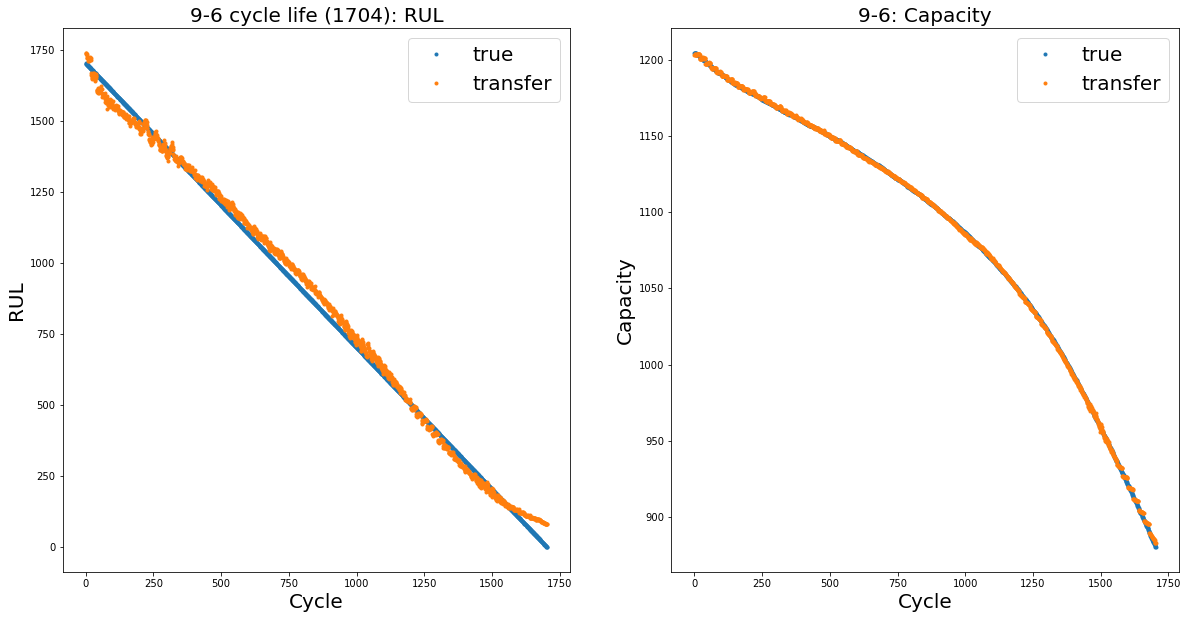

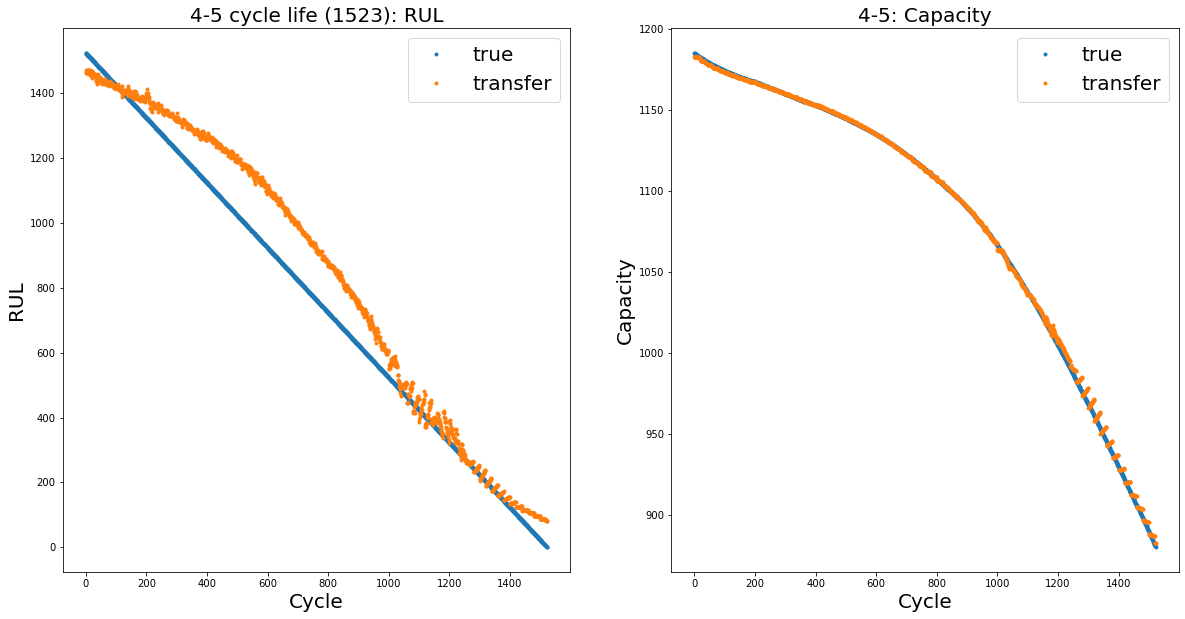

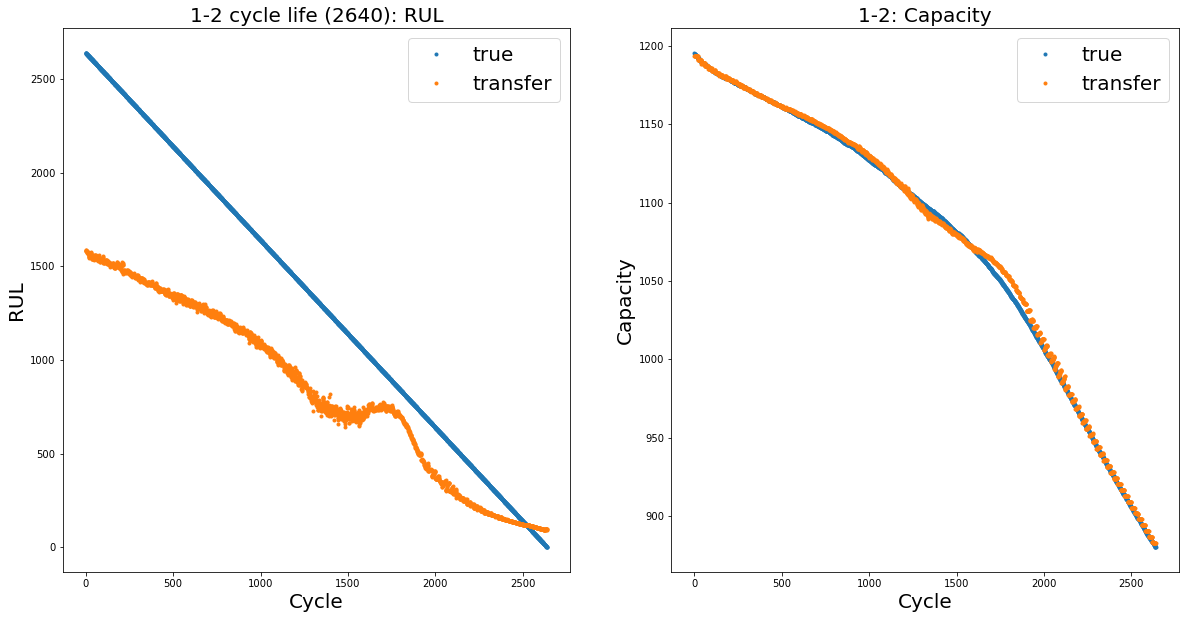

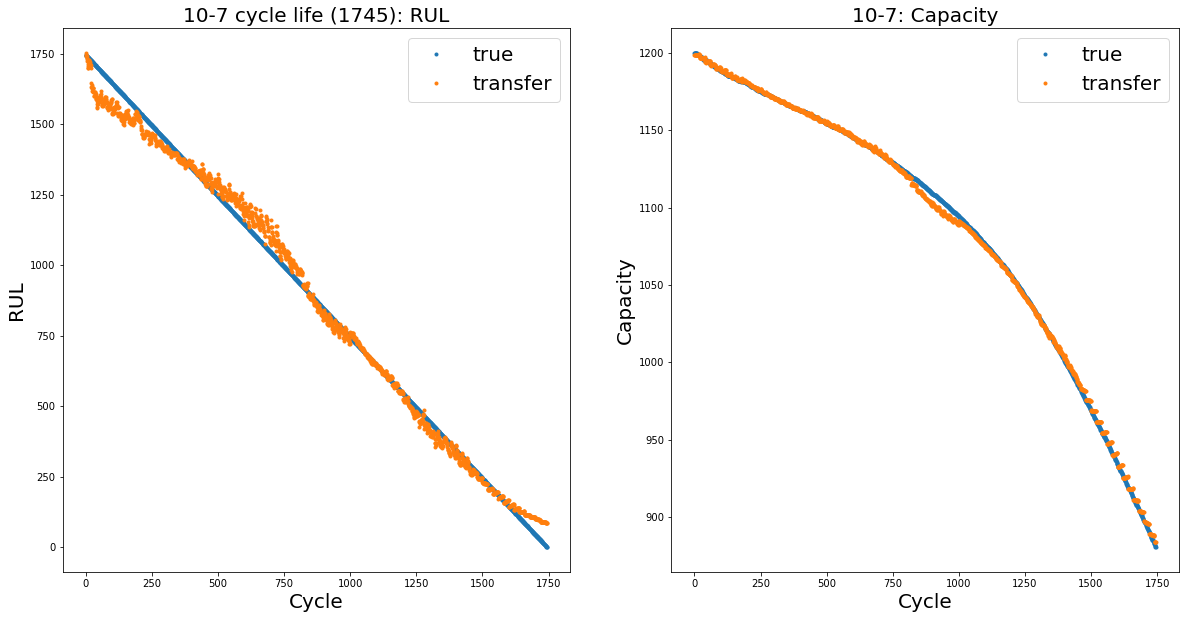

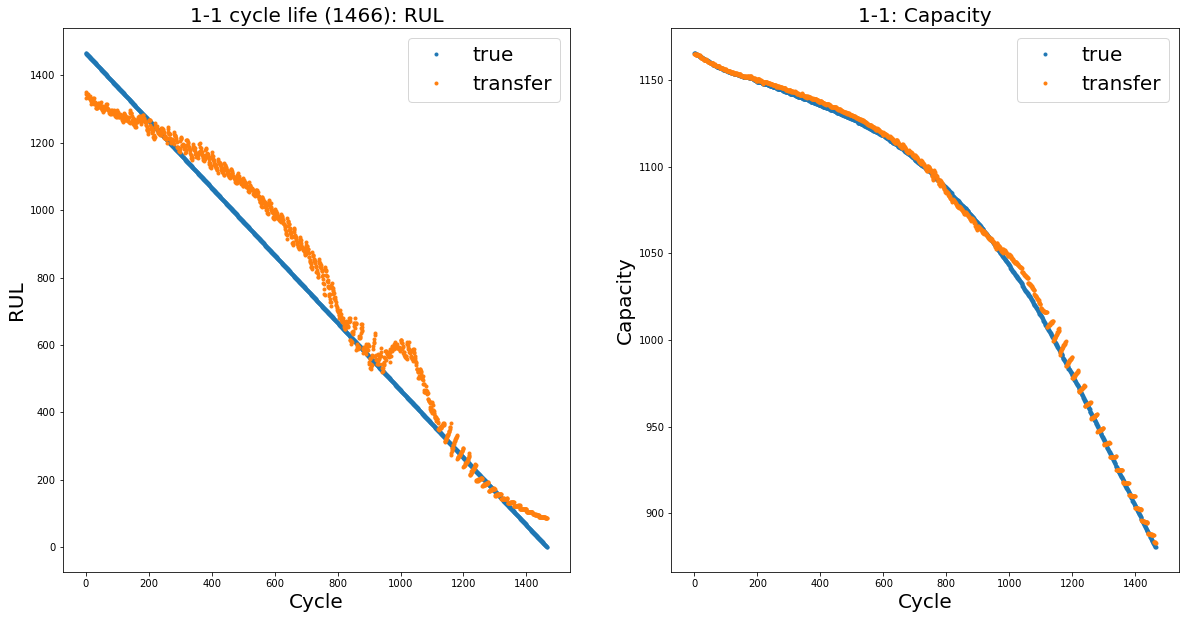

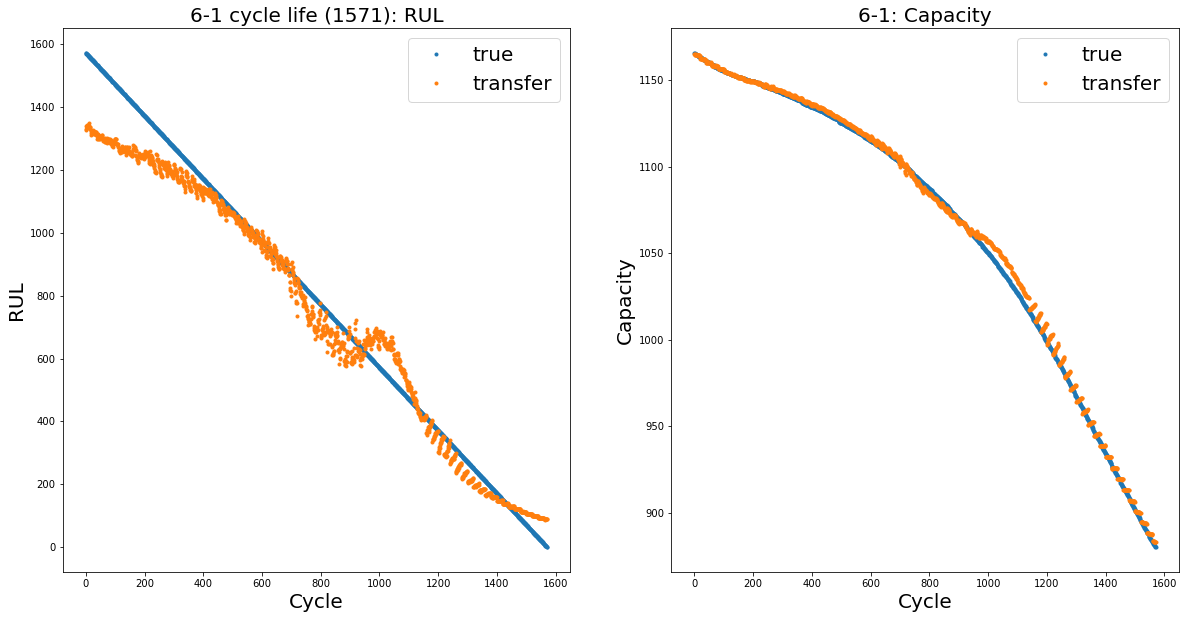

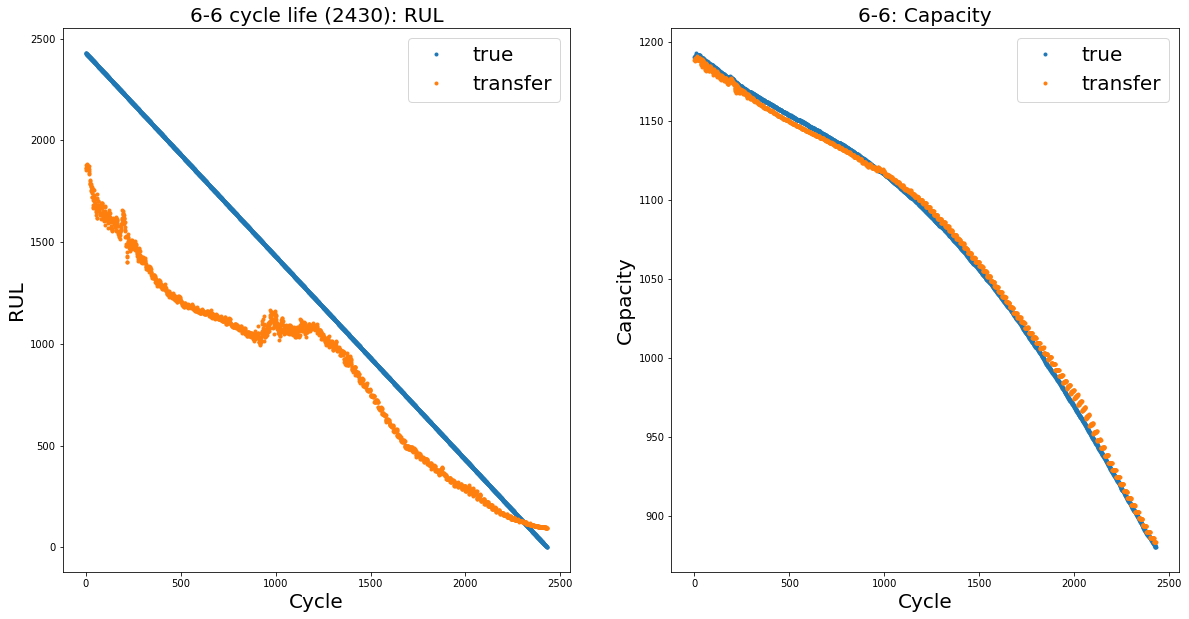

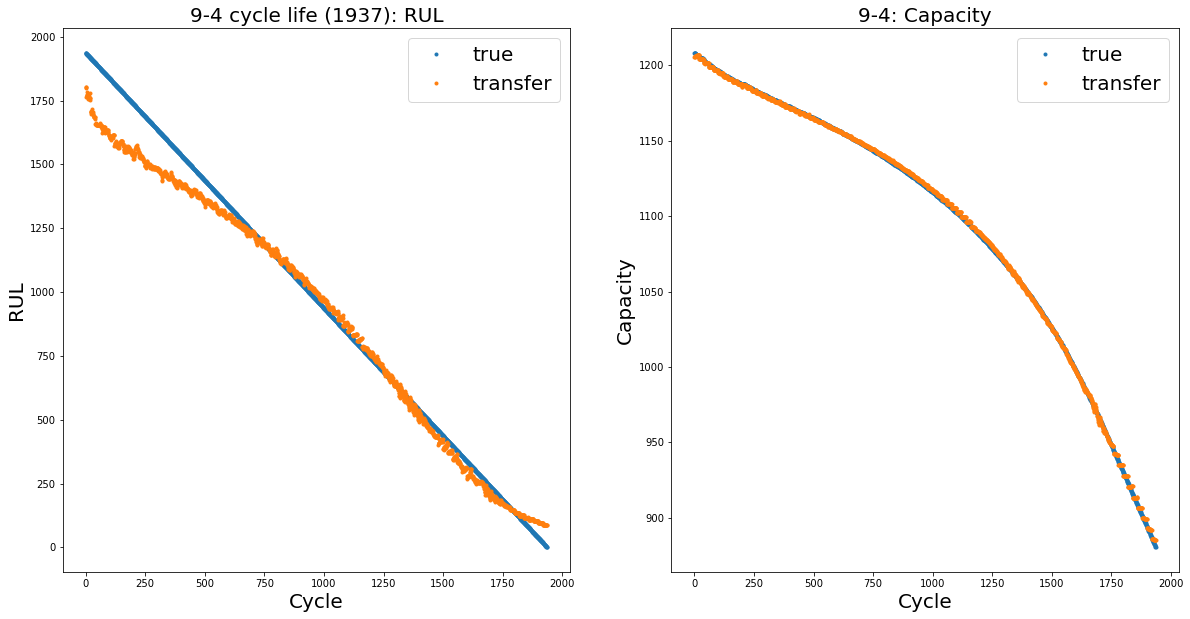

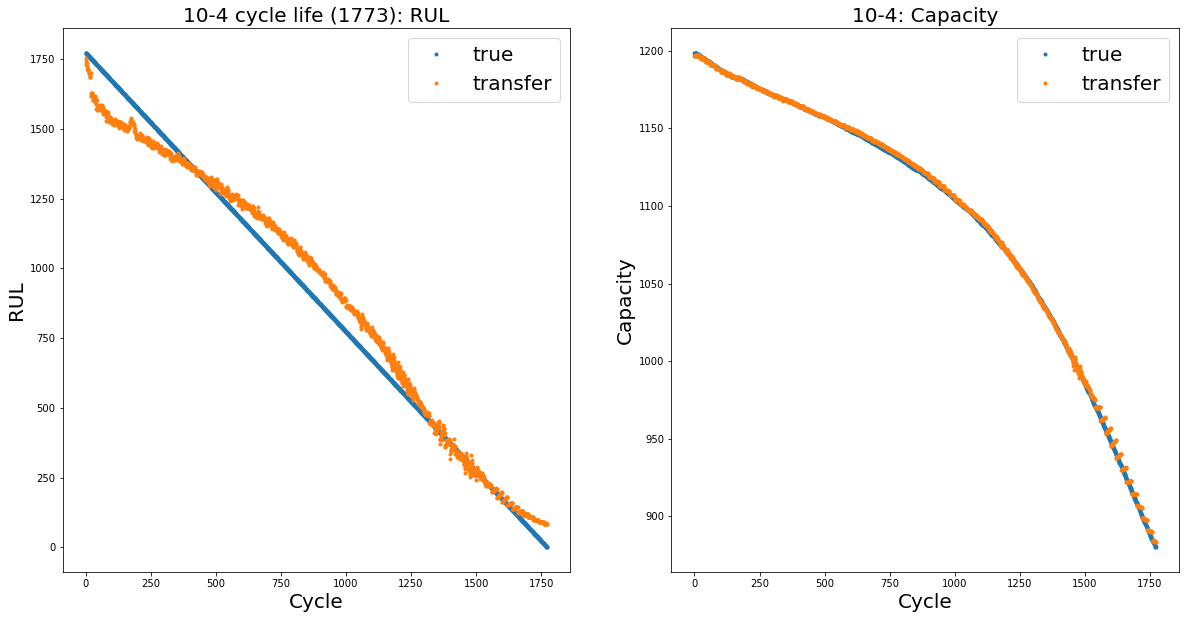

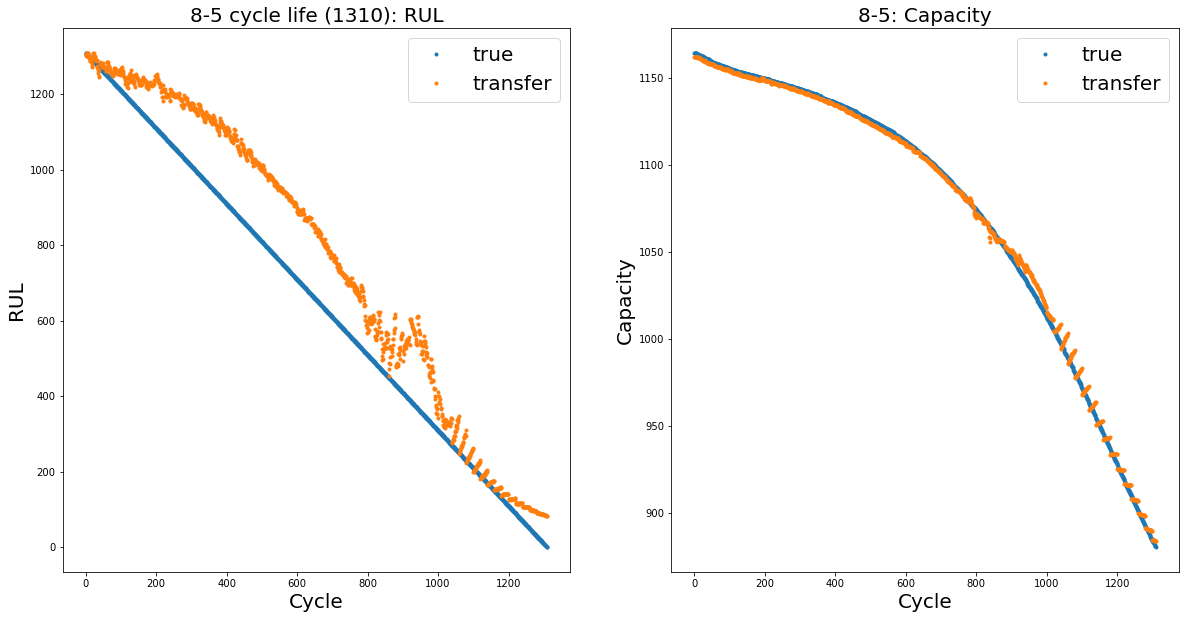

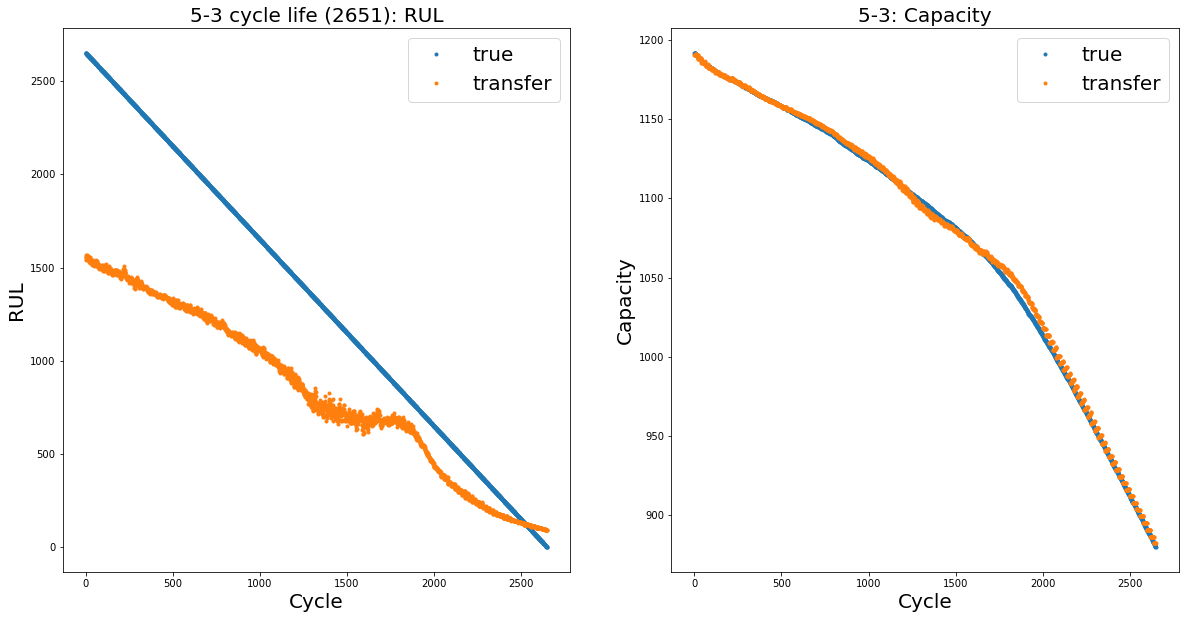

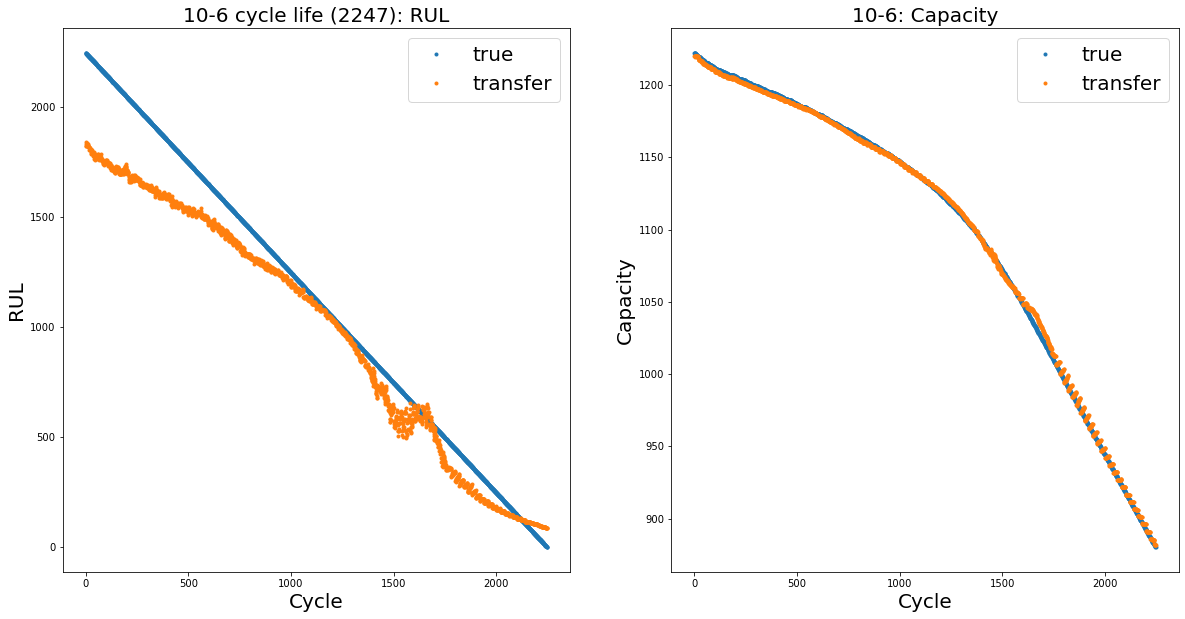

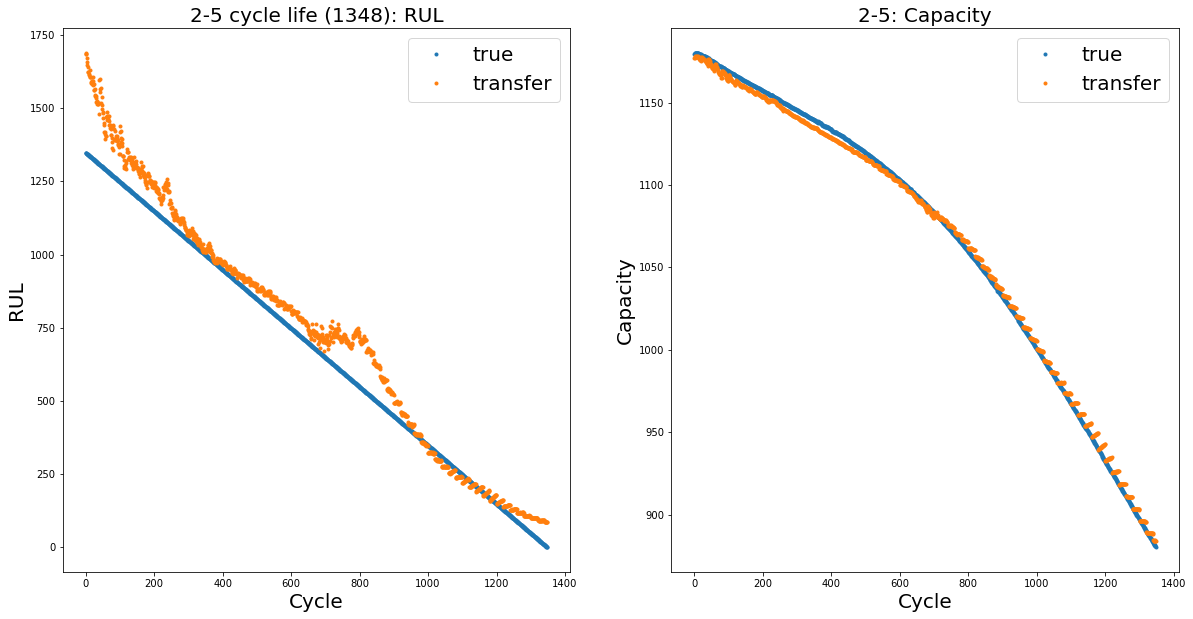

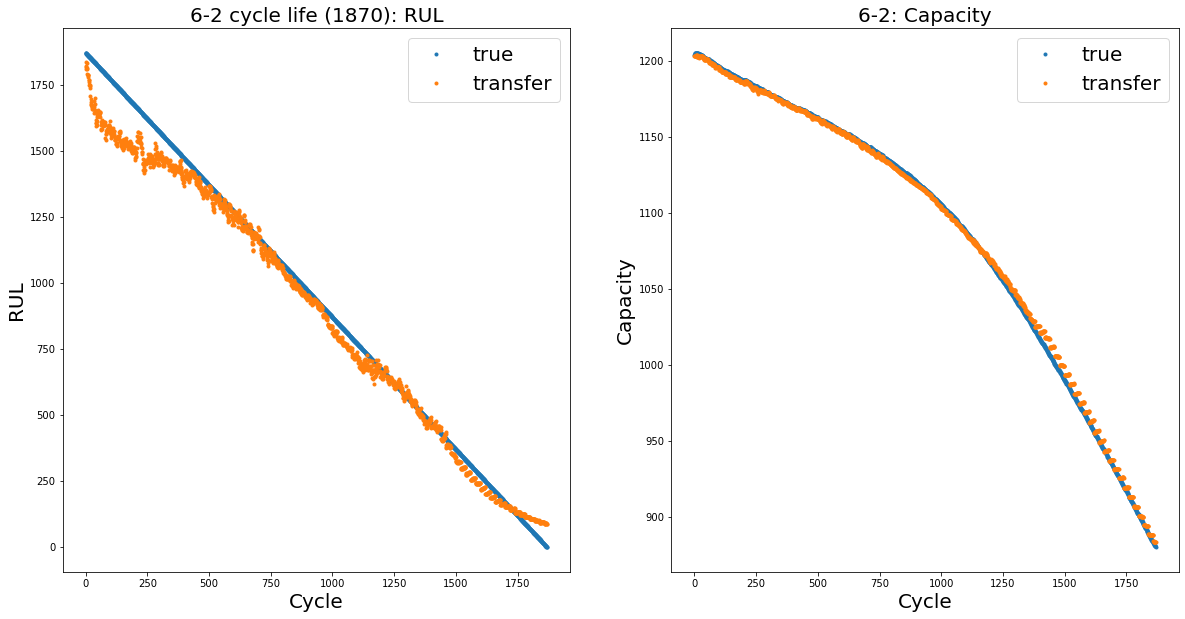

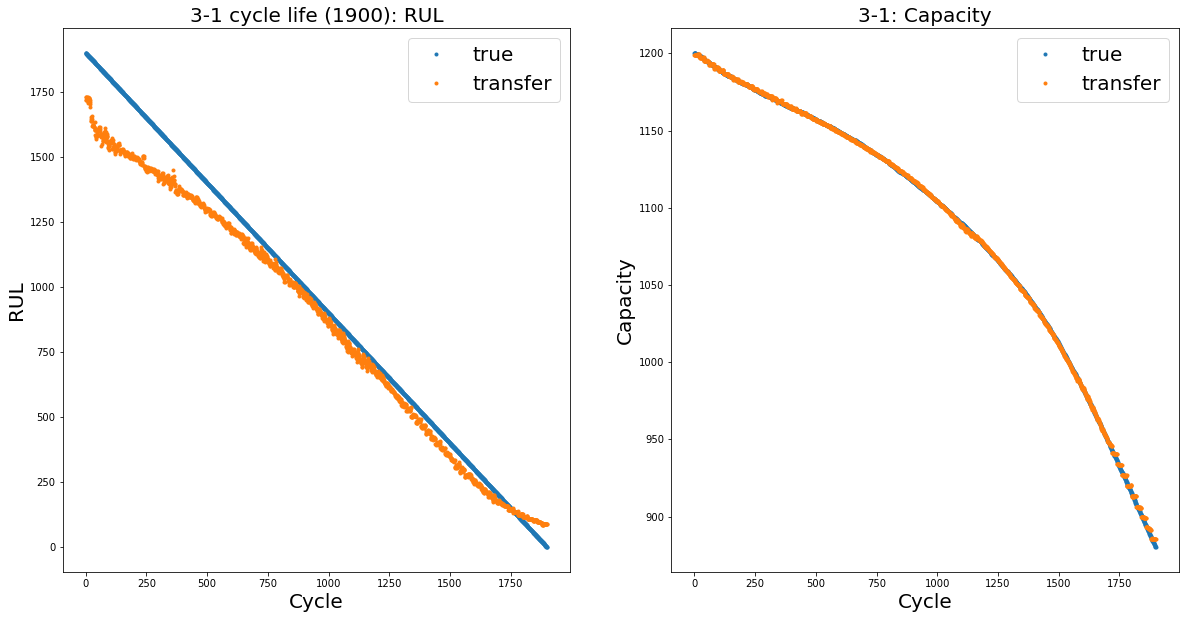

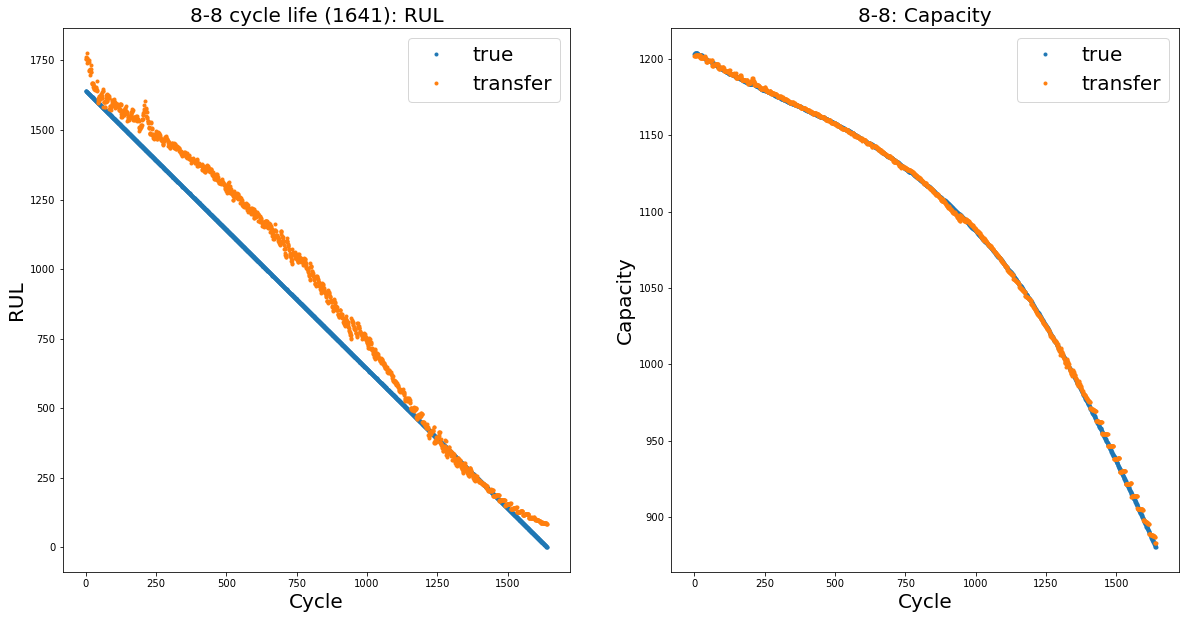

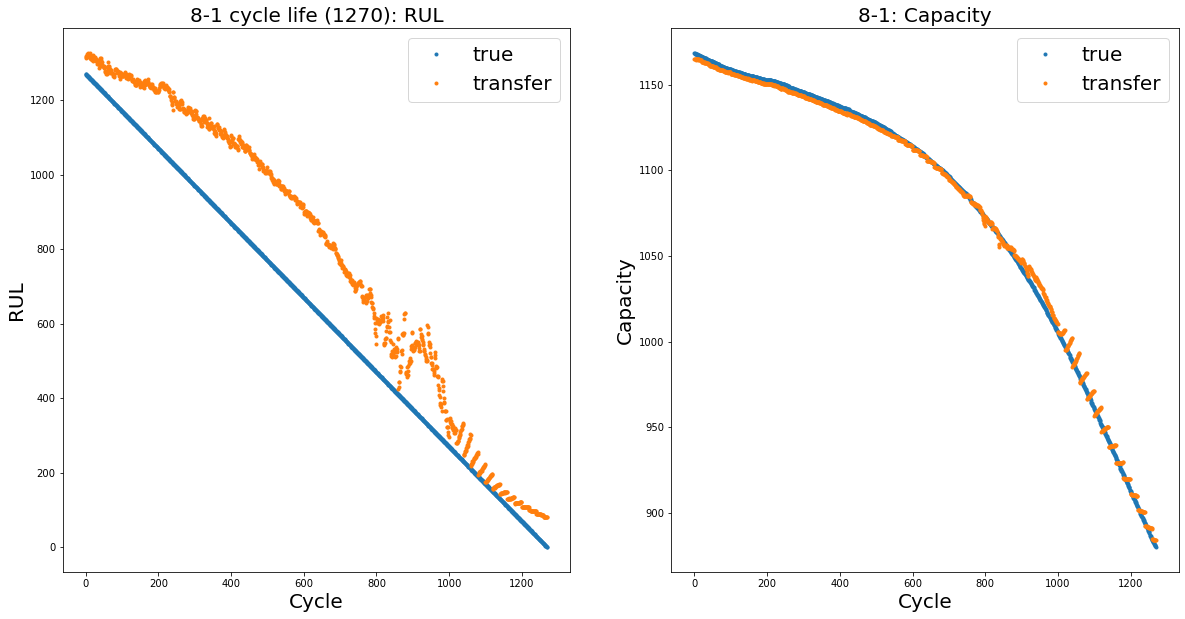

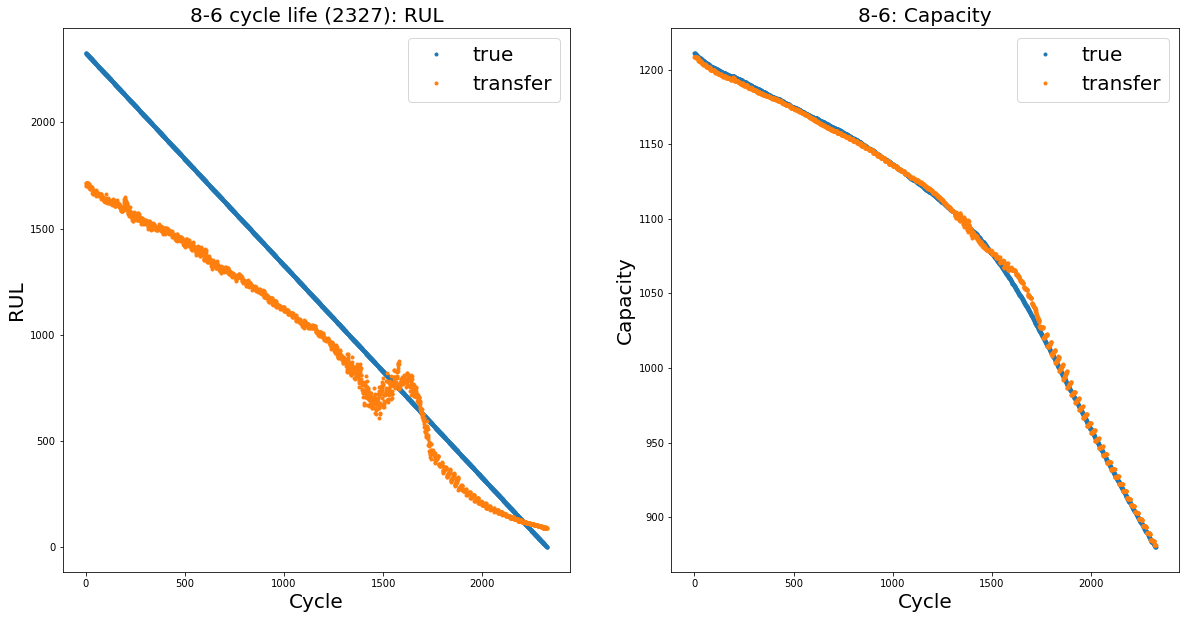

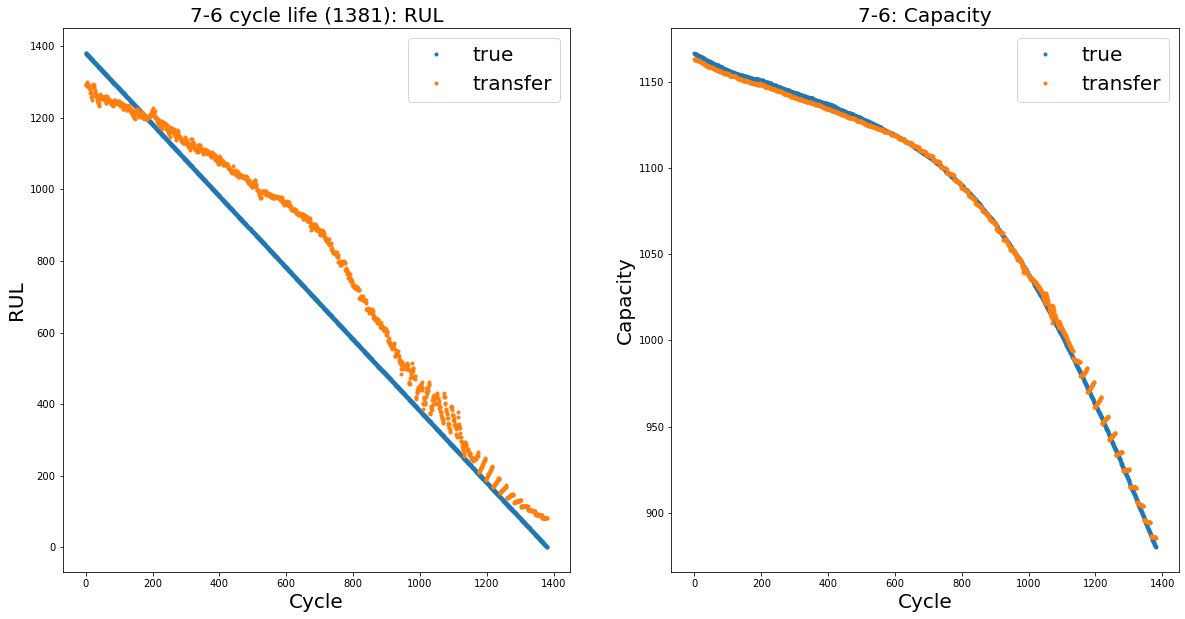

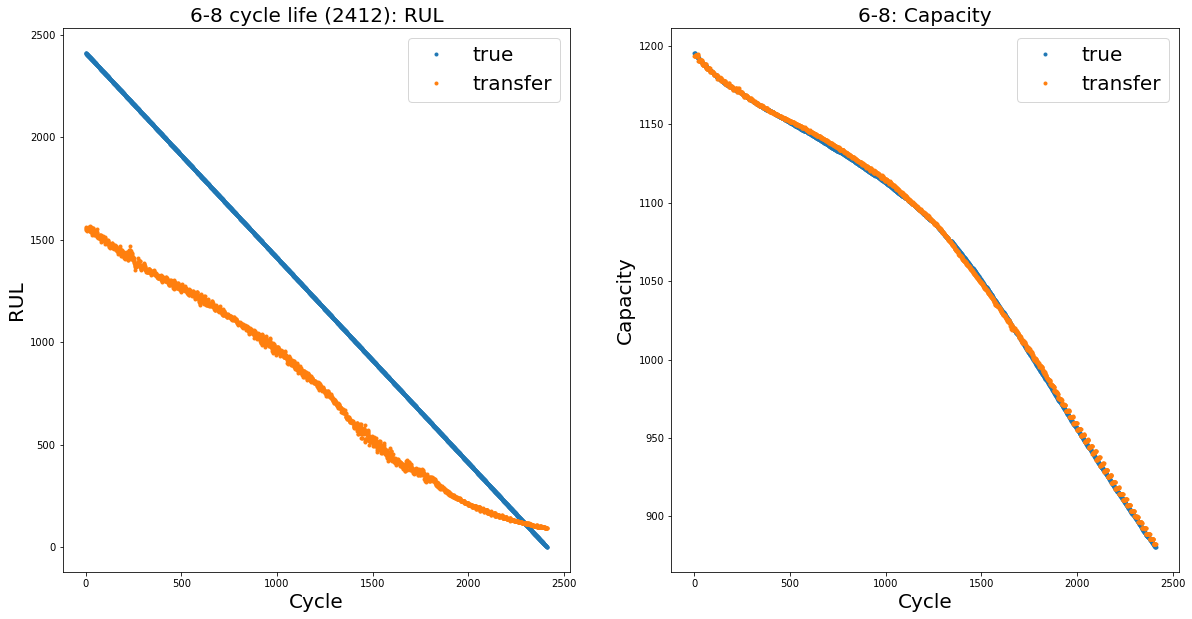

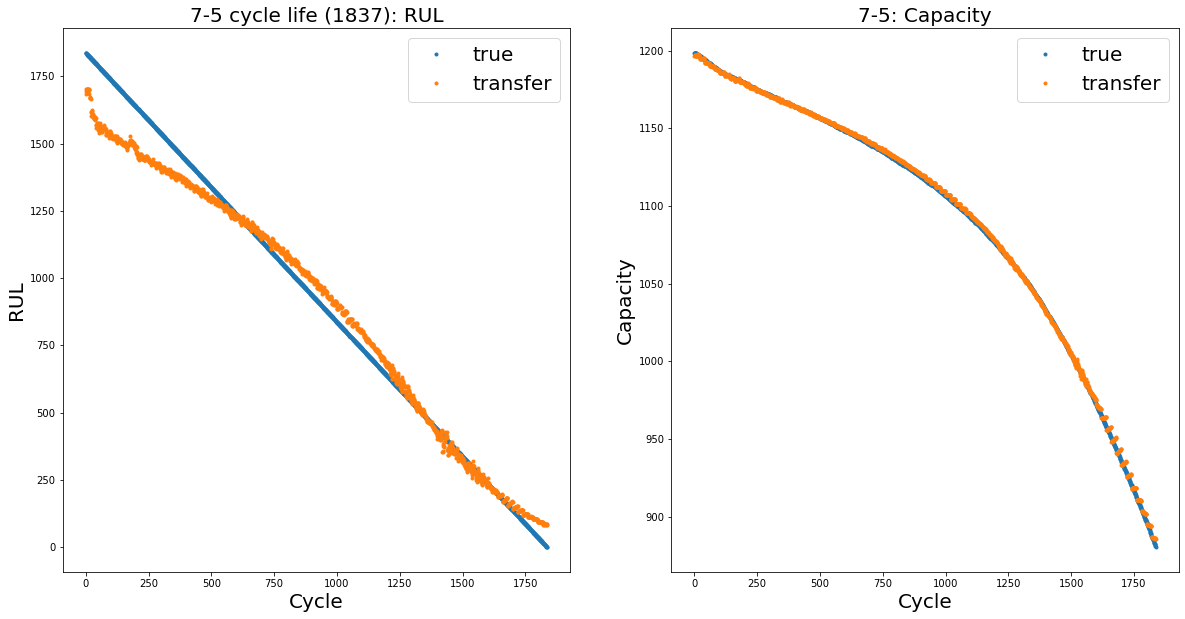

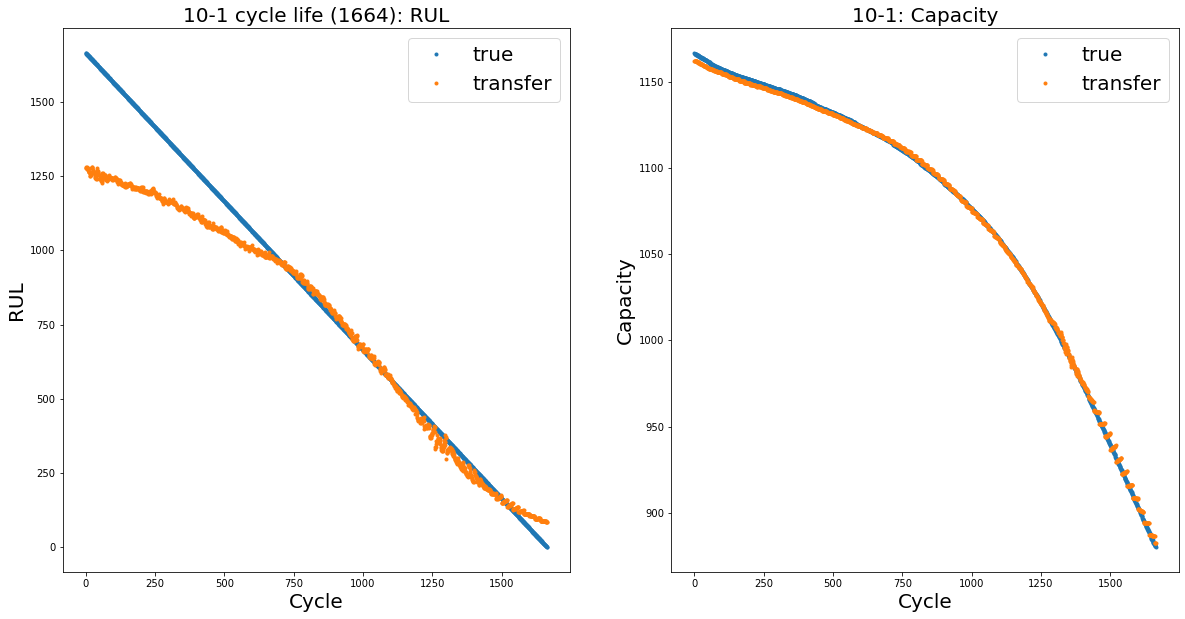

In [18]:
res_dict = {}

for name in new_test[:]:

    stride = 1
    test_fea, test_lbl = [], []
    if name in ign_bat: print('wrong bat')
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    test_fea.append(tmp_fea[::stride])
    test_lbl.append(tmp_lbl[::stride])
    test_fea = np.vstack(test_fea)
    test_lbl = np.vstack(test_lbl).squeeze()

    batch_size = 20 if len(test_fea)%20!=1 else 21
    rul_true, rul_pred, rul_base, SOH_TRUE, SOH_PRED, SOH_BASE = [], [], [], [], [], []
    for i in range(test_fea.shape[0] // batch_size + 1):

        test_fea_ = test_fea[i*batch_size: i*batch_size+batch_size].transpose(0,3,2,1)
        test_lbl_ = test_lbl[i*batch_size: i*batch_size+batch_size]
        testset = TensorDataset(torch.Tensor(test_fea_), torch.Tensor(test_lbl_))
        test_loader = DataLoader(testset, batch_size=batch_size,)
        if test_fea_.shape[0] == 0: continue

        model = CRNN(100,4,64,64,sigmoid=True)
        model = model.to(device)
        model.load_state_dict(torch.load(pretrain_model_path))

        _, y_pred, _, _, soh_pred = trainer.test(test_loader, model)
        rul_base.append(y_pred.cpu().detach().numpy())
        SOH_BASE.append(soh_pred.cpu().detach().numpy())

        for p in model.soh.parameters():
            p.requires_grad = False
        for p in model.rul.parameters():
            p.requires_grad = False
        for p in model.cnn.parameters():
            p.requires_grad = False

        tic = time.time()
        seed_torch(2021)

        num_epochs = 200
        model_load = False
        trainer = FineTrainer(lr = 1e-4, n_epochs = num_epochs,device = device, patience = 1000,
                      lamda = lamda, train_alpha = train_alpha, valid_alpha = valid_alpha, model_name=finetune_model_path)
        model ,train_loss, valid_loss, total_loss, added_loss = trainer.train(test_loader, test_loader, model, model_load)

        y_true, y_pred, mse_loss, soh_true, soh_pred = trainer.test(test_loader, model)
        rul_true.append(y_true.cpu().detach().numpy().reshape(-1,1))
        rul_pred.append(y_pred.cpu().detach().numpy())
        SOH_TRUE.append(soh_true.cpu().detach().numpy())
        SOH_PRED.append(soh_pred.cpu().detach().numpy())

    rul_true = np.vstack(rul_true).squeeze()
    rul_pred = np.vstack(rul_pred).squeeze()
    rul_base = np.vstack(rul_base).squeeze()
    SOH_TRUE = np.vstack(SOH_TRUE)
    SOH_PRED = np.vstack(SOH_PRED)
    SOH_BASE = np.vstack(SOH_BASE)

    fig = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(rul_true[:]*rul_factor, '.',label='true')
    plt.plot(rul_pred[:]*rul_factor, '.',label='transfer')
    plt.legend(fontsize=20)
    plt.title(f'{name} cycle life ({len(test_fea)}): RUL',fontsize=20)
    plt.xlabel('Cycle',fontsize=20)
    plt.ylabel('RUL',fontsize=20)
    plt.subplot(122)
    for seq_num in range(9,10):
        plt.plot(SOH_TRUE[:,seq_num]*cap_factor, '.',label='true')
        plt.plot(SOH_PRED[:,seq_num]*cap_factor, '.',label='transfer')
    plt.legend(fontsize=20)
    plt.title(f'{name}: Capacity',fontsize=20)
    plt.xlabel('Cycle',fontsize=20)
    plt.ylabel('Capacity',fontsize=20)
    plt.show()
    
    res_dict.update({name:{
        'rul':{
            'true':rul_true[:]*rul_factor,
            'base':rul_base[:]*rul_factor,
            'transfer':rul_pred[:]*rul_factor,
        },
        'soh':{
            'true':SOH_TRUE[:,9]*cap_factor,
            'base':SOH_BASE[:,9]*cap_factor,
            'transfer':SOH_PRED[:,9]*cap_factor,
        },
                          }
                    })
    save_obj(res_dict,'./result/ne_dict')

# 5-Result visualization

In [19]:
result = load_obj('result/ne_dict')

In [20]:
new_test  = ['9-6','4-5','1-2', '10-7','1-1', '6-1','6-6', '9-4','10-4','8-5', '5-3','10-6',
            '2-5','6-2','3-1','8-8', '8-1','8-6','7-6','6-8','7-5','10-1']

test_1 = ['1-1','7-5','9-4','10-1','10-4','10-7']
channel_1 = ['#1', '#50', '#65', '#70', '#73', '#76']

test_2 = ['1-2', '5-3','6-1','6-6','6-8']
channel_2 = ['#2','#34', '#39', '#44', '#45']

test_3 = ['2-5','4-5','7-6','8-1','8-8','9-6']
channel_3 = ['#12', '#28', '#51', '#54', '#61', '#67']

test_4 = ['3-1','6-2','8-5','8-6','10-6',]
channel_4 = ['#16', '#40', '#58', '#59', '#75']

Text(0.5, 0, 'Actual RUL (cycles)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


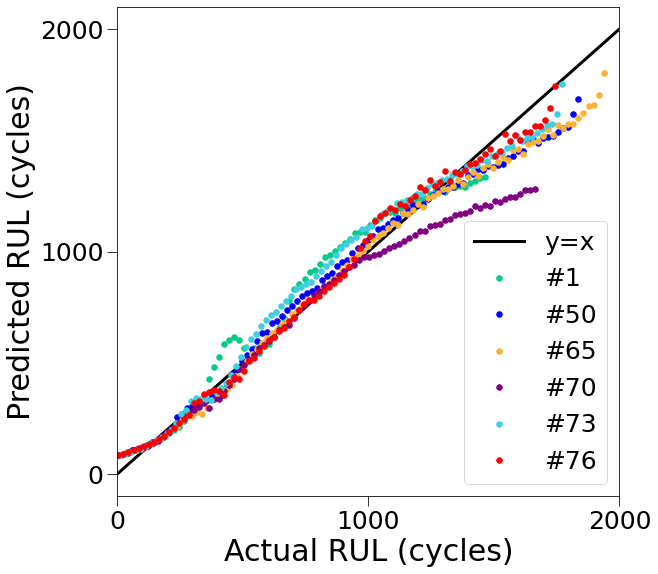

In [21]:
fig = plt.figure(figsize=(9,9))
x_lim = 2000
plt.plot(range(x_lim), range(x_lim),'-',c='k', linewidth=3,label='y=x')
cmap = plt.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0.3, vmax=1)

colors = ['#09C988','b','#FDB137','PURPLE','#40CEE3','red',]

label_names = channel_1[:]
for i, name in enumerate(test_1):
    interval = 20

    rul_true = result[name]['rul']['true'] 
    rul_base = result[name]['rul']['base']
    rul_pred = result[name]['rul']['transfer']
    
    color = [len(rul_true)/2700]*len(rul_true)
    color = color[::interval]

    plt.plot(rul_true[::interval], rul_pred[::interval], '.',markersize=11,label=label_names[i], c=colors[i])
plt.legend(fontsize=25,loc="lower right")
x_major_locator=MultipleLocator(400)
y_major_locator=MultipleLocator(400)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim((0,x_lim))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.xticks([0,1000,2000],size=25)
plt.yticks([0,1000,2000],size=25)

plt.ylabel('Predicted RUL (cycles)',fontsize=30,family='Avenir')
plt.xlabel('Actual RUL (cycles)',fontsize=30,family='Avenir')
# plt.savefig(f'Figure/fig3/rul_1.png',dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'Density')

<Figure size 648x216 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


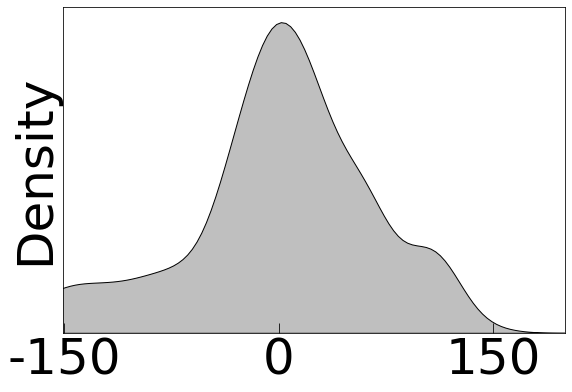

In [22]:
fig = plt.figure(figsize=(9,3))
cmap = plt.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0.3, vmax=1)
error_list = []

colors = ['k','mediumpurple','red','chocolate','limegreen','steelblue',]
label_names = ['#1', '#50','#65','#70', '#73', '#76' ]

for i, name in enumerate(test_1):
    interval = 1

    rul_true = result[name]['rul']['true'] 
    rul_pred = result[name]['rul']['transfer']
    tmp = rul_pred[::interval] - rul_true[::interval]
    error_list.append(tmp.reshape(-1,1))
    
error_array = np.vstack(error_list)

fig = plt.figure(figsize=(9,6))
sns.kdeplot(error_array.squeeze(),shade=True,color='k')
plt.xticks([-150, 0, 150],size=50)
plt.yticks([],size=50)
plt.xlim(-151,200)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.ylabel('Density',fontsize=50,family='Avenir')
# plt.savefig(f'Figure/fig3/drul_1',dpi=1200,bbox_inches='tight')

In [23]:
new_test = test_1 + test_2 + test_3 + test_4
test_channel = channel_1 + channel_2 + channel_3 + channel_4
test_nm_ch = set(zip(test_channel,new_test))

sort_new_test = sorted(test_nm_ch, key = lambda x: int(x[0][1:]))
test_name = [i[0] for i in sort_new_test]
test_channel = [i[1] for i in sort_new_test]
cols = ['rmse_before','rmse_after',
       'r2_before','r2_after',
       'mae_before','mae_after',]

table = pd.DataFrame(index=[test_name,test_channel],columns=cols)
table.loc['All',:] = 0

In [24]:
stride = 1
rmse_before_list, r2_before_list, mae_before_list = [], [], []
rmse_after_list, r2_after_list, mae_after_list = [], [], []


for (code, name) in sort_new_test[:]:
    A = load_obj(f'./data/our_data/{name}')[name]
    end = A['rul'][1]
    
    A_rul = A['rul']
    A_life = A['rul'][1]
    rul_true = result[name]['rul']['true']
    rul_base = result[name]['rul']['base']
    rul_pred = result[name]['rul']['transfer']
    start = end - len(rul_true)
#     print(name, A_life, rul_true[0])
    
    rmse_before = np.sqrt(mean_squared_error(rul_true,rul_base))
    rmse_after = np.sqrt(mean_squared_error(rul_true,rul_pred))
#     print('rmse:','%.3g'%rmse_before,'%.3g'%rmse_after)
    table.loc[(code, name),['rmse_before','rmse_after']] = ['%.3g'%rmse_before, '%.3g'%rmse_after]
    
    r2_before = r2_score(rul_true,rul_base)
    r2_after = r2_score(rul_true,rul_pred)
#     print('r2:','%.3g'%r2_before, '%.3g'%r2_after)
    table.loc[(code, name),['r2_before','r2_after']] = ['%.3g'%r2_before, '%.3g'%r2_after]
    
    mae_before = mean_absolute_error(rul_true,rul_base) / A_life * 100
    mae_after = mean_absolute_error(rul_true, rul_pred) / A_life * 100
#     print('mae/life:','%.3g'%mae_before, '%.3g'%mae_after)
    table.loc[(code, name),['mae_before','mae_after']] = ['%.3g'%mae_before, '%.3g'%mae_after]
    
#     print('')
    
    rmse_before_list.append(rmse_before)
    rmse_after_list.append(rmse_after)
    
    r2_before_list.append(r2_before)
    r2_after_list.append(r2_after)
    
    mae_before_list.append(mae_before)
    mae_after_list.append(mae_after)

table.loc['All',['rmse_before','rmse_after']] = [
                                                                 '%.3g'%np.mean(rmse_before_list), 
                                                                 '%.3g'%np.mean(rmse_after_list)]
table.loc['All',['r2_before','r2_after']] = [
                                                           '%.3g'%np.mean(r2_before_list), 
                                                           '%.3g'%np.mean(r2_after_list)]   
table.loc['All',['mae_before','mae_after']] = [
                                                              '%.3g'%np.mean(mae_before_list), 
                                                              '%.3g'%np.mean(mae_after_list)]

In [25]:
table

,,rmse_before,rmse_after,r2_before,r2_after,mae_before,mae_after
#1,1-1,432,78.6,-0.0443,0.966,26.7,4.31
#2,1-2,1.08e+03,565,-0.998,0.45,35.6,17.9
#12,2-5,529,88.1,-0.849,0.949,34.7,4.78
#16,3-1,475,106,0.25,0.963,21.8,4.21
#28,4-5,433,107,0.0285,0.941,25.2,5.55
#34,5-3,1.09e+03,590,-1.02,0.405,35.8,18.5
#39,6-1,509,86.9,-0.262,0.963,29.3,4.03
#40,6-2,688,76.8,-0.626,0.98,32.1,2.79
#44,6-6,1.19e+03,435,-1.86,0.616,42.1,14.4
#45,6-8,938,488,-0.815,0.509,33.8,17.7
